In [38]:
import os
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

"""Please upload csv files to the same directoy as this program. Details of the
conda env, including versions of libraries used may be found in the .yml file.
Cells should be run sequentially, from top to bottom."""

folder_path = os.getcwd()  # Variable to hold current folder path
files_in_folder = os.listdir(folder_path)  # Create directory list
conn = None

def load_csv(files_in_folder, folder_path):

    csv_dict = {}  # dictionary to hold DataFrames
    
    for file_name in files_in_folder:
        if file_name.endswith('.csv'): # check whether file is csv 
            file_path = os.path.join(folder_path, file_name)  # Construct full file path
            
            try:
                df = pd.read_csv(file_path) #create dataframe
                csv_dict[file_name] = df # add to dictionary
            except Exception as e:
                print(f"Failed to load {file_name}: {e}")
    print("Loaded CSV files:", list(csv_dict.keys())) # confirm that desired dataframes have been created   
    return csv_dict

def rename(csv_dict, rename_map):
    renamed_dict = {}

    # Define a rename map for fixing the 'Attendence' typo to 'Attendance'
    additional_rename_map = {'Attendence': 'Attendance'}

    for name, df in csv_dict.items():
        # Rename columns based on the rename_map
        renamed_df = df.rename(columns=rename_map)

        # Check if the 'Component' column exists before replacing the typo
        if 'Component' in renamed_df.columns:
            renamed_df['Component'] = renamed_df['Component'].replace(additional_rename_map)

        # Check if both 'Date' and 'Time' columns exist in the DataFrame
        if 'Date' in renamed_df.columns and 'Time' in renamed_df.columns:
            print(f"Sample data from '{name}' DataFrame:")
            print(renamed_df[['Date', 'Time']].head())  # Print the first few rows of Date and Time

            # Remove the '00:00' part from the 'Date' column (split by space and keep the date part)
            renamed_df['Date'] = renamed_df['Date'].str.split(' ', expand=True)[0].str.strip()

            # Convert the 'Date' column to datetime (dd/mm/yyyy format)
            renamed_df['Date'] = pd.to_datetime(renamed_df['Date'], format='%d/%m/%Y', errors='coerce')

            renamed_df['Time'] = renamed_df['Time'].str.strip()  # Ensure any extra spaces are removed

            # Combine the 'Date' and 'Time' into a single 'DateTime' column
            renamed_df['DateTime'] = pd.to_datetime(
                renamed_df['Date'].dt.strftime('%d/%m/%Y') + ' ' + renamed_df['Time'], 
                format='%d/%m/%Y %H:%M:%S', 
                errors='coerce'  # Handle any invalid DateTime combinations
            )

            # Drop the original 'Date' and 'Time' columns after combining
            renamed_df.drop(['Date', 'Time'], axis=1, inplace=True)

        # Add the updated DataFrame to the renamed_dict
        renamed_dict[name] = renamed_df

    return renamed_dict

def merge(renamed_dict, how='inner'):

    # Filter out DataFrames that have the 'User_ID' column
    matching_dfs = {name: df for name, df in renamed_dict.items() if 'User_ID' in df.columns}

    # If no matching DataFrames are found, return None
    if not matching_dfs:
        print("No DataFrames with the 'User_ID' column found.")
        return None

    # Start with the first DataFrame in the matching_dfs dictionary
    merged_df = list(matching_dfs.values())[0]
    first_df_user_ids = merged_df['User_ID']

    # Merge remaining DataFrames one by one, based on 'User_ID'
    for df in list(matching_dfs.values())[1:]:
        print(f"Merging DataFrame with {df.shape[0]} rows...")

        # Ensure both DataFrames have the same number of rows
        if len(merged_df) != len(df):
            raise ValueError("The DataFrames being merged do not have the same number of rows. "
                             "Please ensure both DataFrames are aligned in terms of row count.")
        
        # Check if User_IDs match row by row
        second_df_user_ids = df['User_ID']
        
        if not all(first_df_user_ids == second_df_user_ids):
            print("Warning: User_IDs do not match between the DataFrames!")
            # Flag or handle the error (e.g., raise an exception, or just warn)
            return None
                
        # Drop the 'User_ID' column from the second DataFrame to avoid duplication
        df = df.drop(columns=['User_ID'])

        # If User_IDs match, concatenate (merge) the DataFrames
        merged_df = pd.concat([merged_df, df], axis=1)

    return merged_df

def handle_missing_values(merged_df):
    clean_df = merged_df.dropna()
    return clean_df  

def remove_duplicate_rows(merged_df):
    if not isinstance(merged_df, pd.DataFrame):
        raise ValueError("Input should be a pandas DataFrame.")
    
    # Count the number of duplicate rows
    num_duplicates = merged_df.duplicated(keep='first').sum()
    
    # Remove duplicate rows
    deduplicated_df = merged_df.drop_duplicates(keep='first')
    
    # Print a message about the number of rows removed
    if num_duplicates > 0:
        print(f"Removed {num_duplicates} duplicate rows from the DataFrame.")
    else:
        print("No duplicate rows were found to remove.")
    
    return deduplicated_df

def init_db_connection(db_name="Student_Activity_Data.db"):
    global conn
    if conn is None:
        conn = sqlite3.connect(db_name)

def close_db_connection():
    global conn
    if conn is not None:
        conn.close()
        conn = None

def csv_to_sql(clean_df, data_manager, db_name="Student_Activity_Data.db"):
    # Fetch the table name
    table_name = data_manager.get_table_name()

    # Connect to the database
    init_db_connection(db_name)

    # Create the SQL table from the DataFrame
    clean_df.to_sql(table_name, conn, if_exists='replace', index=False)

    # Create index on the 'Component' column        
    cursor = conn.cursor()
    create_index_sql_component = f"""
    CREATE INDEX IF NOT EXISTS idx_component ON {table_name}(Component);
    """
    cursor.execute(create_index_sql_component)

    # Create index on the 'User_ID' column
    create_index_sql_user_id = f"""
    CREATE INDEX IF NOT EXISTS idx_user_id ON {table_name}(User_ID);
    """
    cursor.execute(create_index_sql_user_id)

    # Close the database connection
    close_db_connection()

def remove(data_manager, db_name="Student_Activity_Data.db"):
    # Initialize the database connection
    init_db_connection(db_name)
    cursor = conn.cursor()
    
    # Fetch table name and validate
    table_name = data_manager.get_table_name()
    if not table_name:
        raise ValueError("Table name must be set in DataManager before calling 'reshape'.")
 
    # Delete rows where 'Component' is 'System' or 'Folder'
    delete_query = f"""
    DELETE FROM {table_name}
    WHERE Component IN ('System', 'Folder');
    """
    cursor.execute(delete_query)
    conn.commit()

    # Close the database connection
    close_db_connection()

def reshape(data_manager, months, start_month=None, end_month=None, components=None, 
            db_name="Student_Activity_Data.db"):
    # Connect to database
    init_db_connection(db_name)

    # Retrieve table name
    table_name = data_manager.get_table_name()
    
    # Filter months 
    if start_month and end_month:
        months = [month for month in months if start_month <= month <= end_month]

    # Fetch data and filter by components 
    components_list = [f"'{comp}'" for comp in components]  
    components_filter = f"AND Component IN ({', '.join(components_list)})" if components else ""

    # Construct SQL query to pivot data
    month_columns = ", ".join([ 
        f"SUM(CASE WHEN strftime('%Y-%m', DateTime) = '{month}' THEN 1 ELSE 0 END) AS `{month}`" 
        for month in months
    ])
    
    # retrieve user inteactions by month and group by ID and component
    query = f"""
    SELECT 
        User_ID, 
        Component, 
        {month_columns},
        SUM(CASE WHEN strftime('%Y-%m', DateTime) IN ({', '.join(f"'{month}'" for month in months)}) 
        THEN 1 ELSE 0 END) AS Total_Interactions
    FROM {table_name}
    WHERE 1=1 {components_filter}
    GROUP BY User_ID, Component
    ORDER BY User_ID, Component;
    """

    # Convert to dataframe for further manipulation
    df = pd.read_sql(query, conn)

    # Close the database connection after operation
    close_db_connection()

    return df

def prep_data(csv_dict, data_manager):
    # check files have been uploaded
    if csv_dict is None:
        print("Error: No data loaded. Please load the data first using Option 1.\n")
        return

    # Rename columns
    rename_map = {"User Full Name *Anonymized": "User_ID"}
    renamed_dict = rename(csv_dict, rename_map)

   #  Merge data
    merged_df = merge(renamed_dict, how='inner')

    # Handle missing values
    clean_df = handle_missing_values(merged_df)

    # Remove duplicate rows
    cleaner_df = remove_duplicate_rows(clean_df)

    # Export to SQL
    csv_to_sql(cleaner_df, data_manager, db_name="Student_Activity_Data.db")

    # Remove unwanted files or clean up
    remove(data_manager)
   
class DataManager:
    def __init__(self):
        # variables to hold table and database names
        self.table_name = None  
        self.db_name = "Student_Activity_Data.db"  
    
    def set_table_name(self, table_name):
        self.table_name = table_name

    def get_table_name(self):
        return self.table_name

    def get_all_table_names(self):
        init_db_connection(self.db_name)  

        try:
            query = "SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;"
            cursor = conn.cursor()
            cursor.execute(query)
            tables = cursor.fetchall()

            # Flatten the list of tuples and return as a list of table names
            return [table[0] for table in tables]  # Extract the table name from the tuple

        except Exception as e:
            print(f"An error occurred while fetching table names: {e}")
            return []

        finally:
            close_db_connection()  

    # Check whether table exists in the database
    def table_exists(self, table_name):

        return table_name in self.get_all_table_names()
    
    # Fetch month range of currently-selected table
    def get_available_months(self):

        table_name = self.get_table_name()  
        
        if not table_name:
            raise ValueError("Table name must be set before getting available months.")

        db_name = "Student_Activity_Data.db"  
        init_db_connection(db_name)

        try:
            # SQL query to get distinct months from the DateTime column for the selected table
            query = f"""
            SELECT DISTINCT strftime('%Y-%m', DateTime) AS month
            FROM {table_name}
            ORDER BY month;
            """
        
            cursor = conn.cursor()
            cursor.execute(query)
            months = cursor.fetchall()
            
            # Flatten the list of tuples and return as a list of months
            return [month[0] for month in months]  # Extract the month from the tuple

        except Exception as e:
            print(f"An error occurred: {e}")
            return []

        finally:
            close_db_connection()

def compute_stats(filtered_data, components, relevant_months):
    # list to hold results
    combined_stats = []
    for component in components:
        # Compute statistics for each month
        for month in relevant_months:
            month_data = filtered_data[filtered_data["Component"] == component][month]
            combined_stats.append({
                'Component': component,
                'Month': month,
                'Mean': month_data.mean(),
                'Median': month_data.median(),
                'Mode': month_data.mode().iloc[0] if not month_data.mode().empty else None
            })
        # Compute aggregated total views across all months for the component
        component_data = filtered_data[filtered_data["Component"] == component]
        component_data['Total_Views'] = component_data[relevant_months].sum(axis=1)
        combined_stats.append({
            'Component': component,
            'Month': 'All Months',
            'Mean': component_data['Total_Views'].mean(),
            'Median': component_data['Total_Views'].median(),
            'Mode': component_data['Total_Views'].mode().iloc[0] if not component_data['Total_Views'].mode().empty else None
        })
    return combined_stats

def render_stats_table(stats_df):
    # Extract column names
    columns = list(stats_df.columns)
    
    # Prepare rows with horizontal separators
    rows = []
    previous_component = None

    for _, row in stats_df.iterrows():
        # Add a horizontal separator row (whitespace) when the component changes
        if row['Component'] != previous_component:
            # Separator row (empty values) with the "whitespace" tag
            rows.append(([""] * len(columns), "whitespace"))
        
        # Add the actual row as a list with the "normal" tag
        rows.append((row.tolist(), "normal"))

        # Update previous_component
        previous_component = row['Component']

    return columns, rows

def display_stats(data_manager, start_month, end_month):
    # Fetch table name and validate
    table_name = data_manager.get_table_name()
    if not table_name:
        raise ValueError("Table name is not set in DataManager.")
    
    # Define components to analyze
    components = ["Quiz", "Lecture", "Assignment", "Attendance", "Survey"]

    # Generate the list of months between start_month and end_month
    relevant_months = (pd.date_range(start=start_month, end=end_month, freq='MS')
                       .strftime('%Y-%m').tolist())

    # Preprocess data (reshape and filter)
    filtered_data = reshape(data_manager, months=relevant_months, start_month=start_month, 
                            end_month=end_month, components=components)
    
    # Compute stats
    combined_stats = compute_stats(filtered_data, components, relevant_months)
    
    # Combine stats into a single DataFrame and round values
    stats_df = pd.DataFrame(combined_stats)  
    stats_df[['Mean', 'Median', 'Mode']] = stats_df[['Mean', 'Median', 'Mode']].round(1)
    
    # Generate the table structure
    return render_stats_table(stats_df)

def plot_line_graph(data, x, y, hue, title, xlabel, ylabel):
    # set background style
    sns.set(style="whitegrid")
    
    # set axes 
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Create plot, set colours, add data points
    sns.lineplot(data=data, x=x, y=y, hue=hue, marker='o', ax=ax)
    
    # Set title
    ax.set_title(title)
    
    # Label x axis
    ax.set_xlabel(xlabel)
    
    # Label y axis
    ax.set_ylabel(ylabel)
    
    # Set legend colour
    ax.legend(title=hue)
    
    # Prevent overlapping and improbve readability
    plt.setp(ax.get_xticklabels(), rotation=45)
    
    return fig

def display_interaction_graph(data_manager, start_month, end_month):
    # Fetch table name and validate
    table_name = data_manager.get_table_name()

    # Define components to analyze
    components_of_interest = ["Assignment", "Quiz", "Lecture", "Book", "Project", "Course"]

    # Generate the list of months between start_month and end_month
    relevant_months = (pd.date_range(start=start_month, end=end_month, freq='MS').strftime('%Y-%m')
                       .tolist())

    # Preprocess data (reshape and filter)
    filtered_data = reshape(data_manager, months=relevant_months, start_month=start_month, 
                            end_month=end_month, components=components_of_interest)

    # Melt to long format for grouping
    long_data = filtered_data.melt(id_vars=['User_ID', 'Component'], 
                                   value_vars=relevant_months, 
                                   var_name='Month', 
                                   value_name='Interactions')

    # Convert 'Month' column to a categorical type for correct ordering
    long_data['Month'] = pd.Categorical(long_data['Month'], categories=relevant_months, ordered=True)

    # Aggregate total interactions per component per month
    total_data = long_data.groupby(['Component', 'Month']).Interactions.sum().reset_index()

    # Plot total interactions
    fig = plot_line_graph(total_data, x='Month', y='Interactions', hue='Component',
                          title=f"Total Interactions Per Component ({start_month} to {end_month})",
                          xlabel="Month", ylabel="Total Interactions")

    return fig

def calculate_pearson_correlation(component_data):
    x = component_data['Total_Interactions']
    y = component_data['User_ID']
    
    # Compute the covariance and standard deviations
    covariance = np.cov(x, y)[0][1]
    std_x = np.std(x, ddof=1)
    std_y = np.std(y, ddof=1)

    # Pearson correlation coefficient
    correlation = covariance / (std_x * std_y)
    return correlation

def plot_scatterplot(total_data, component, start_month, end_month, correlation):
    # Proceed with plotting
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Scatterplot based on the total interactions (aggregated data)
    sns.scatterplot(data=total_data, x='Total_Interactions', y='User_ID', hue='Component', palette='viridis', ax=ax)
    
    ax.set_title(f"User Activity vs. {component} Interactions ({start_month} to {end_month})")
    ax.set_xlabel("Total User Interactions")
    ax.set_ylabel("User ID")
    ax.legend(title="Component")
    plt.tight_layout()

    # Add the Pearson correlation as text on the plot
    ax.text(0.95, 0.95, f'Pearson Correlation: {correlation:.2f}', 
            transform=ax.transAxes, ha='right', va='top', fontsize=12, color='red')
    
    return fig

def display_scatterplot(data_manager, start_month, end_month):
    # Components to analyze
    components_of_interest = ["Assignment", "Quiz", "Lecture", "Book", "Project", "Course"]

    # Generate the list of months between start_month and end_month
    months_range = (pd.date_range(start=start_month, end=end_month, freq='MS').strftime('%Y-%m')
                    .tolist())

    # Preprocess the data (reshape and filter)
    filtered_data = reshape(data_manager, months=months_range, start_month=start_month, 
                            end_month=end_month, components=components_of_interest)

    # Calculate interactions across the whole time frame
    total_interactions_per_user = (filtered_data.groupby(['User_ID', 'Component'])
                                   ['Total_Interactions'].sum().reset_index())

    # Dictionary to store figures for each component and Pearson correlations
    scatterplots = {}
    pearson_correlations = {}

    for component in components_of_interest:
        # Filter data for the current component
        component_data = (total_interactions_per_user[total_interactions_per_user
                                                      ['Component'] == component])

        # Calculate Pearson correlation for the current component and store
        correlation = calculate_pearson_correlation(component_data)
        pearson_correlations[component] = correlation

        # Generate the scatterplot for the current component and store
        fig = plot_scatterplot(component_data, component, start_month, end_month, correlation)
        scatterplots[component] = fig

    return scatterplots, pearson_correlations

def exit_program():
    print("Exiting the program. Goodbye!")
    exit()




Loaded CSV files: ['ACTIVITY_LOG.csv', 'COMPONENT_CODES.csv', 'USER_LOG.csv']
Sample data from 'USER_LOG.csv' DataFrame:
               Date       Time
0  17/11/2023 00:00   00:00:00
1  10/11/2023 00:00   00:00:01
2  10/11/2023 00:00   00:00:02
3  20/12/2023 00:00   00:00:02
4  20/12/2023 00:00   00:00:03
Merging DataFrame with 150835 rows...
Removed 2770 duplicate rows from the DataFrame.


C:\Users\spenc\AppData\Local\Temp\ipykernel_2956\3593865463.py:347: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  component_data['Total_Views'] = component_data[relevant_months].sum(axis=1)
C:\Users\spenc\AppData\Local\Temp\ipykernel_2956\3593865463.py:347: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  component_data['Total_Views'] = component_data[relevant_months].sum(axis=1)
C:\Users\spenc\AppData\Local\Temp\ipykernel_2956\3593865463.py:347: SettingWithCopyWarning: 
A value is trying to be set on a copy o

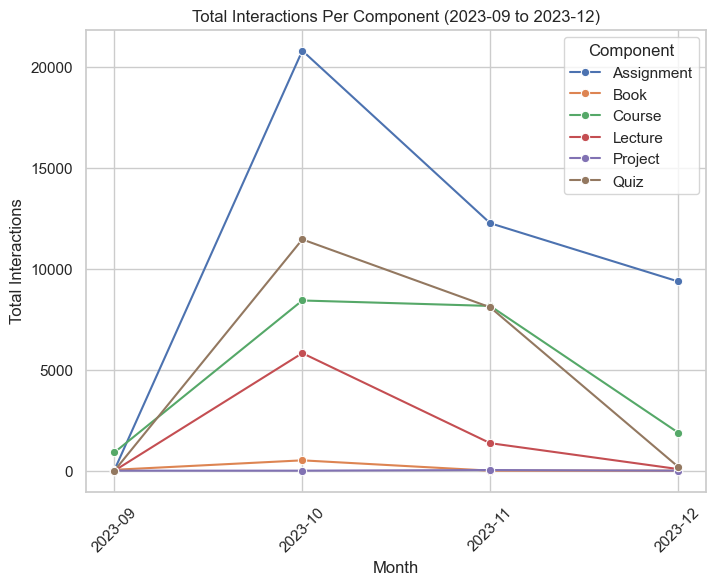

In [ ]:
import tkinter as tk
from tkinter import messagebox, ttk, simpledialog
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg


class Tooltip:
    def __init__(self, widget, text):
        self.widget = widget
        self.text = text
        self.tooltip_window = None

        widget.bind("<Enter>", self.show_tooltip)
        widget.bind("<Leave>", self.hide_tooltip)

    def show_tooltip(self, event):
        if self.tooltip_window is not None:
            return

        # Create tooltip window
        self.tooltip_window = tk.Toplevel(self.widget)
        self.tooltip_window.withdraw()  # Start hidden
        self.tooltip_window.overrideredirect(True)  # No window decorations
        self.tooltip_window.geometry(f"+{event.x_root + 10}+{event.y_root + 10}")

        # Create label inside the tooltip
        label = tk.Label(
            self.tooltip_window,
            text=self.text,
            background="yellow",
            relief="solid",
            borderwidth=1,
            font=("Helvetica", 10)
        )
        label.pack()

        self.tooltip_window.deiconify()  # Show the tooltip window

    def hide_tooltip(self, event):
        if self.tooltip_window:
            self.tooltip_window.destroy()
            self.tooltip_window = None

class DataAnalysisApp(tk.Tk):
    def __init__(self):
        super().__init__()
        self.title("Student Activity Analyser")
        self.geometry("400x300")

        # Instantiate DataManager to handle data management tasks
        self.data_manager = DataManager()

        # Program logic functions as class attributes
        self.load_csv = load_csv
        self.prep_data = prep_data
        self.display_stats = display_stats
        self.display_interaction_graph = display_interaction_graph
        self.display_scatterplot = display_scatterplot

        # Application state
        self.csv_dict = None
        self.data_loaded = False
        self.data_prepped = False

        # Dropdown values for table selection
        self.table_names = []
        self.selected_table_name = tk.StringVar(self)

        # Example folder path and file list
        self.files_in_folder = files_in_folder
        self.folder_path = folder_path

        # Setup all widgets (labels, buttons, dropdown, etc.)
        self.setup_buttons()

    def setup_buttons(self):

        # Set the overall background color of the window to off-white
        self.configure(bg='#f4f4f4')  # Very light gray background for a cleaner look

        # Make border for the main window visible
        self['bd'] = 1  # Border weight around the entire window
        self['relief'] = 'solid'
        self['borderwidth'] = 1  
        self['highlightbackground'] = '#000080'  # Navy blue border around the window

        # Configure grid to control row heights and prevent unnecessary stretching
        self.grid_rowconfigure(0, weight=0)  # Top row with the headings
        self.grid_rowconfigure(1, weight=1)  # Row for main content (left and right frames)
        self.grid_rowconfigure(2, weight=0, minsize=40)  # Exit button row 

        self.grid_columnconfigure(0, weight=1, uniform="equal")  # Left column
        self.grid_columnconfigure(1, weight=1, uniform="equal")  # Right column

        # Create frames for the left and right columns with matching light gray background
        left_frame = tk.Frame(self, bg='#f4f4f4', bd=0)  # No border for internal frames
        left_frame.grid(row=1, column=0, padx=20, pady=10, sticky="n")

        right_frame = tk.Frame(self, bg='#f4f4f4', bd=0)  # No border for internal frames
        right_frame.grid(row=1, column=1, padx=20, pady=10, sticky="n")

        # Add headings for each column with navy blue text
        data_prep_label = tk.Label(left_frame, text="Data Preparation", font=("Helvetica", 14, "bold"), fg="#000080", bg='#f4f4f4')
        data_prep_label.grid(row=0, column=0, pady=(10, 15), sticky="w")

        analysis_label = tk.Label(right_frame, text="Analysis", font=("Helvetica", 14, "bold"), fg="#000080", bg='#f4f4f4')
        analysis_label.grid(row=0, column=0, pady=(10, 15), sticky="w")

        # Standardize button width, background, and border colors
        button_width = 20
        button_bg = "#cfe2f3"  # Soft pastel blue button background
        button_fg = "#000080"  # Navy blue text for buttons
        button_border = "#000080"  # Navy blue border for buttons

        # Buttons for "Data Preparation" column (Left column)
        load_data_button = tk.Button(left_frame, text="1. Load Data", command=self.load_csv_call, width=button_width, bg=button_bg, fg=button_fg, bd=1, relief="solid", highlightbackground=button_border)
        load_data_button.grid(row=1, column=0, pady=5, padx=(0, 10), sticky="ew")  
        Tooltip(load_data_button, "Upload files from current folder for analysis")

        prep_data_button = tk.Button(left_frame, text="2. Prep Data", command=self.prep_data_call, width=button_width, bg=button_bg, fg=button_fg, bd=1, relief="solid", highlightbackground=button_border)
        prep_data_button.grid(row=2, column=0, pady=5, padx=(0, 10), sticky="ew")  
        Tooltip(prep_data_button, "Merge and clean data, and export to database")

        # Buttons for "Analysis" column (Right column)
        display_stats_button = tk.Button(right_frame, text="Display Averages", command=self.display_stats_call, width=button_width, bg=button_bg, fg=button_fg, bd=1, relief="solid", highlightbackground=button_border)
        display_stats_button.grid(row=1, column=0, pady=5, padx=(0, 10), sticky="ew")  
        Tooltip(display_stats_button, "Display average user interactions with components by month")

        display_interaction_graph_button = tk.Button(right_frame, text="Display Trends", command=self.display_interaction_graph_call, width=button_width, bg=button_bg, fg=button_fg, bd=1, relief="solid", highlightbackground=button_border)
        display_interaction_graph_button.grid(row=2, column=0, pady=5, padx=(0, 10), sticky="ew")  
        Tooltip(display_interaction_graph_button, "Check monthly user interactions with components")

        display_scatterplot_button = tk.Button(right_frame, text="Display Correlations", command=self.display_scatterplot_call, width=button_width, bg=button_bg, fg=button_fg, bd=1, relief="solid", highlightbackground=button_border)
        display_scatterplot_button.grid(row=3, column=0, pady=5, padx=(0, 10), sticky="ew")  
        Tooltip(display_scatterplot_button, "Analyze correlations between users and components")

        # Exit button centered at the bottom 
        exit_btn = tk.Button(self, text="Exit", command=self.destroy, width=button_width, bg=button_bg, fg=button_fg, bd=1, relief="solid", highlightbackground=button_border)
        exit_btn.grid(row=2, column=0, columnspan=2, pady=(0, 10))  
        Tooltip(exit_btn, "Exit the program")

        # Set window size 
        self.geometry("400x250")  
        self.minsize(400, 250)  

    def load_csv_call(self):
        if self.files_in_folder and self.folder_path:
            # Check if there are any CSV files in the folder
            csv_files = [file for file in self.files_in_folder if file.endswith('.csv')]
            
            if not csv_files:
                messagebox.showerror("Error", "Please upload CSV files to the program directory.")
                return
            
            try:
                # Load the CSV files if they exist
                self.csv_dict = self.load_csv(csv_files, self.folder_path)
                self.data_loaded = True
                self.data_prepped = False
                messagebox.showinfo("Info", f"Files successfully loaded from {self.folder_path}!")
            except Exception as e:
                messagebox.showerror("Error", f"An error occurred while loading files: {e}")
        else:
            messagebox.showerror("Error", "No files or folder path provided.")

    def prep_data_call(self):
        try:
            # Check if data has been loaded 
            if not self.data_loaded:
                messagebox.showerror("Error", "No data has been loaded. Please load data first.")
                return  # Exit if data not loaded

            # Open a dialog to input a new table name
            new_table_name = self.prompt_new_table_name()
            if not new_table_name:
                return  # User canceled the operation

            # Ensure the new table name is unique
            if self.data_manager.table_exists(new_table_name):
                # Ask user for confirmation before overwriting
                overwrite_confirm = messagebox.askyesno(
                    "Confirm Overwrite",
                    f"This will overwrite the existing table '{new_table_name}'. Are you sure you wish to proceed?"
                )
                if not overwrite_confirm:
                    return  # User canceled the operation

            # Set the table name in the DataManager
            self.data_manager.set_table_name(new_table_name)
            
            # Call prep_data to perform the data processing and SQL export
            prep_data(self.csv_dict, self.data_manager)  

        except Exception as e:
            messagebox.showerror("Error", f"An error occurred: {e}")

    def prompt_new_table_name(self):
        new_table_name = simpledialog.askstring("New Table Name", "Enter a name for the new table:")
        return new_table_name.strip() if new_table_name else None

    def prompt_select_table_name(self):
        try:
            # Fetch available table names
            table_names = self.data_manager.get_all_table_names()
            
            if not table_names:
                messagebox.showerror("Error", "No tables available to select.")
                return None

            # Create window for the dialog
            table_selector = tk.Toplevel(self)
            table_selector.title("Select Table Name")
            table_selector.geometry("300x150")
            table_selector.grab_set()  # Make the window modal

            # Variable to hold the selected table name
            selected_table = tk.StringVar(value=table_names[0])  # Default to the first table

            # Add label and dropdown
            tk.Label(table_selector, text="Select a Table:", font=("Helvetica", 12)).pack(pady=10)
            table_dropdown = ttk.Combobox(table_selector, textvariable=selected_table, values=table_names)
            table_dropdown.pack(pady=10)

            # Result container for the selected table
            result = {"table_name": None}

            def submit_selection():
                """Confirm the selection and close the dialog."""
                result["table_name"] = selected_table.get()
                table_selector.destroy()

            def cancel_selection():
                """Cancel the selection and close the dialog."""
                result["table_name"] = None
                table_selector.destroy()

            # Add Submit and Cancel buttons
            tk.Button(table_selector, text="Submit", command=submit_selection).pack(side="left", padx=10, pady=10)
            tk.Button(table_selector, text="Cancel", command=cancel_selection).pack(side="right", padx=10, pady=10)

            # Wait for the user to close the window
            table_selector.wait_window()

            return result["table_name"]

        except Exception as e:
            messagebox.showerror("Error", f"An error occurred: {e}")
            return None

    def select_month_range(self):
        try:
            # Fetch available months using DataManager
            available_months = self.data_manager.get_available_months()

            # Raise an error if no months are available
            if not available_months:
                raise ValueError("No available months found in the database.")

            # Create a new Toplevel window for the dialog
            month_selector = tk.Toplevel(self)
            month_selector.title("Select Month Range")
            month_selector.geometry("300x200")
            month_selector.grab_set()  # Make the window modal

            # Variables to hold the selected months
            start_month = tk.StringVar(value=available_months[0])
            end_month = tk.StringVar(value=available_months[-1])

            # Label for instructions
            tk.Label(month_selector, text="Select Start and End Month", font=("Helvetica", 14)).pack(pady=10)

            # Dropdown for start month
            tk.Label(month_selector, text="Start Month:").pack()
            start_month_dropdown = ttk.Combobox(month_selector, textvariable=start_month, values=available_months)
            start_month_dropdown.pack(pady=5)

            # Dropdown for end month
            tk.Label(month_selector, text="End Month:").pack()
            end_month_dropdown = ttk.Combobox(month_selector, textvariable=end_month, values=available_months)
            end_month_dropdown.pack(pady=5)

            # Placeholder to hold the result
            result = {"selection": None}

            def submit_selection():
                start = start_month.get()
                end = end_month.get()

                if available_months.index(start) > available_months.index(end):
                    messagebox.showerror("Error", "Start month must be before or the same as end month.")
                else:
                    result["selection"] = (start, end)
                    month_selector.destroy()

            def cancel_selection():
                result["selection"] = None
                month_selector.destroy()

            # Buttons for Submit and Cancel
            tk.Button(month_selector, text="Submit", command=submit_selection).pack(pady=10)
            tk.Button(month_selector, text="Cancel", command=cancel_selection).pack()

            # Wait for user interaction
            month_selector.wait_window()

            return result["selection"]

        except Exception as e:
            messagebox.showerror("Error", f"An error occurred: {e}")
            return None
    
    def display_stats_call(self):
        try:
            # Prompt the user to select a table name via the popup
            table_name = self.prompt_select_table_name()

            # If the user cancels, stop the process
            if not table_name:
                return

            # Set the table name in the data manager
            self.data_manager.set_table_name(table_name)

            # Fetch available months
            available_months = self.data_manager.get_available_months()
            if not available_months:
                messagebox.showerror("Error", "No available months in the selected table.")
                return

            # Call the method to select a month range
            selected_months = self.select_month_range()
            if not selected_months:
                messagebox.showerror("Error", "No valid months selected.")
                return

            # Get table structure from display_stats
            columns, rows = self.display_stats(self.data_manager, selected_months[0], selected_months[-1])

            if not rows:
                messagebox.showinfo("Info", "No statistics found for the selected range.")
                return

            # Create a new window for the stats
            stats_window = tk.Toplevel(self)
            stats_window.title("Statistics")
            stats_window.geometry("800x400")

            # Add a Treeview widget
            tree = ttk.Treeview(stats_window, columns=columns, show="headings")
            tree.pack(expand=True, fill="both")

            # Configure column headings
            for col in columns:
                tree.heading(col, text=col)
                tree.column(col, anchor=tk.CENTER, width=100)

            # Add rows to the Treeview with appropriate tags
            for row, tag in rows:
                tree.insert("", "end", values=row, tags=(tag,))

            # Add a scrollbar
            scrollbar = ttk.Scrollbar(stats_window, orient="vertical", command=tree.yview)
            tree.configure(yscroll=scrollbar.set)
            scrollbar.pack(side="right", fill="y")

            # Style the rows based on their tags
            tree.tag_configure("whitespace", background="#AEC6CF")  # Pastel blue for whitespace rows
            tree.tag_configure("normal", background="white")       # White for normal rows

        except Exception as e:
            messagebox.showerror("Error", f"An error occurred: {e}")

    def display_interaction_graph_call(self):
        try:
            # Prompt the user to select a table name
            table_name = self.prompt_select_table_name()

            # If no table name is selected, stop the process
            if not table_name:
                return

            # Set the table name in the DataManager
            self.data_manager.set_table_name(table_name)

            # Get the available months for the selected table
            available_months = self.data_manager.get_available_months()
            if not available_months:
                messagebox.showerror("Error", "No available months in the selected table.")
                return

            # Open the month range selection dialog
            selected_months = self.select_month_range()
            if not selected_months:
                messagebox.showerror("Error", "No valid months selected.")
                return

            # Create a new window for the interaction graph
            graph_window = tk.Toplevel(self)
            graph_window.title("Interaction Graph")
            graph_window.geometry("800x600")

            # Generate the interaction graph and embed it in the GUI
            fig = self.display_interaction_graph(self.data_manager, selected_months[0], selected_months[-1])

            canvas = FigureCanvasTkAgg(fig, master=graph_window)
            canvas_widget = canvas.get_tk_widget()
            canvas_widget.pack(fill=tk.BOTH, expand=True)
            canvas.draw()

        except Exception as e:
            messagebox.showerror("Error", f"An error occurred while generating the interaction graph: {e}")
            
    def display_scatterplot_call(self):
        try:
            # Prompt the user to select a table name
            table_name = self.prompt_select_table_name()

            # If no table name is selected, stop the process
            if not table_name:
                return

            # Set the table name in the DataManager
            self.data_manager.set_table_name(table_name)

            # Get the available months for the selected table
            available_months = self.data_manager.get_available_months()
            if not available_months:
                messagebox.showerror("Error", "No available months in the selected table.")
                return

            # Open the month range selection dialog
            selected_months = self.select_month_range()
            if not selected_months:
                messagebox.showerror("Error", "No valid months selected.")
                return

            # Generate scatterplots and correlations for the selected months
            scatterplots, pearson_correlations = self.display_scatterplot(self.data_manager, selected_months[0], selected_months[-1])

            # Create a new window to display the scatterplots
            scatter_window = tk.Toplevel(self)
            scatter_window.title("Scatterplot Viewer")
            scatter_window.geometry("800x600")

            # Dropdown menu for selecting a component
            selected_component = tk.StringVar(scatter_window)
            selected_component.set(list(scatterplots.keys())[0])  # Default to the first component

            def update_plot(*args):
                """Update the displayed plot based on the dropdown selection."""
                component = selected_component.get()
                canvas.figure = scatterplots[component]
                canvas.draw()

            selected_component.trace("w", update_plot)

            # Create the dropdown menu in the scatter window
            dropdown = ttk.Combobox(scatter_window, textvariable=selected_component, values=list(scatterplots.keys()))
            dropdown.pack(pady=10)

            # Create a canvas to display the initial plot
            canvas = FigureCanvasTkAgg(scatterplots[selected_component.get()], master=scatter_window)
            canvas_widget = canvas.get_tk_widget()
            canvas_widget.pack(fill=tk.BOTH, expand=True)

            # Display the initial plot
            canvas.draw()

            # Optionally, display Pearson correlation information somewhere in the window
            info_label = tk.Label(scatter_window, text=f"Pearson Correlations: {pearson_correlations}")
            info_label.pack(pady=10)

        except Exception as e:
            messagebox.showerror("Error", f"An error occurred while generating scatterplots: {e}")

# Run the app
if __name__ == "__main__":
    app = DataAnalysisApp()
    app.mainloop()

